In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from collections import defaultdict
import os


📝 First 5 Rows of Dataset:
    User ID Product ID                Category    Brand    Price  Views Count  \
0  U0017918   P0004499         Home Appliances       LG  6566.90           75   
1  U0002824   P0003700  Beauty & Personal Care  L'Oréal  1934.87           66   
2  U0000662   P0004552                 Fashion   Adidas  6964.26           40   
3  U0013875   P0004055           Personal Care  Philips  2543.27           75   
4  U0010805   P0000514         Home Appliances       LG  5358.27            5   

   Cart Addition  Purchase Count  Rating Review Text  ...  Order ID  \
0              0               1       5        Good  ...  O1879562   
1              1               1       1     Not bad  ...  O6564739   
2              0               0       2        Poor  ...       NaN   
3              0               0       3     Not bad  ...       NaN   
4              1               0       4        Good  ...       NaN   

  Payment Method Discount Used Return Status      Search Q

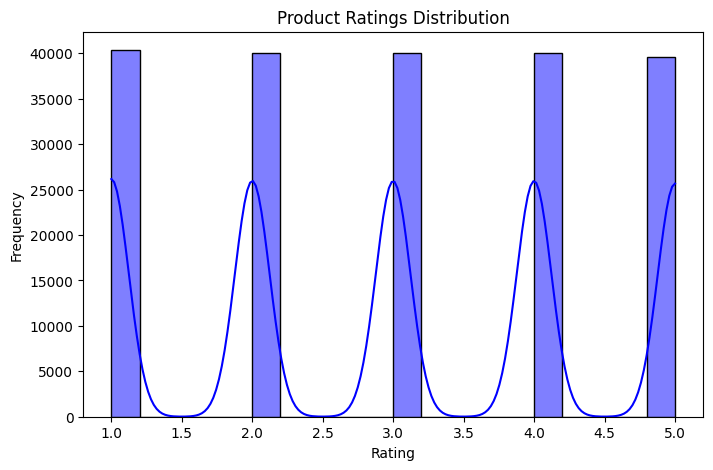


✅ Cleaned dataset saved successfully!


In [2]:
file_path = "final_dataset.csv"
df = pd.read_csv(file_path)

print("\n📝 First 5 Rows of Dataset:")
print(df.head())

print("\n📊 Dataset Information:")
print(df.info())

print("\n🔍 Missing Values Count:")
print(df.isnull().sum())

df.columns = df.columns.str.strip().str.lower()

print("✅ Final column names:", df.columns)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

df.drop_duplicates(inplace=True)

plt.figure(figsize=(8, 5))
sns.histplot(df['rating'].dropna(), bins=20, kde=True, color='blue')
plt.title("Product Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

if 'rating_count' in df.columns:
    top_products = df.groupby('product_name')['rating_count'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_products.values, y=top_products.index, palette="coolwarm")
    plt.title("Top 10 Most Rated Products")
    plt.xlabel("Total Ratings")
    plt.ylabel("Product Name")
    plt.show()

cleaned_file_path = "cleaned_ecommerce_data.csv"
df.to_csv(cleaned_file_path, index=False)
print("\n✅ Cleaned dataset saved successfully!")


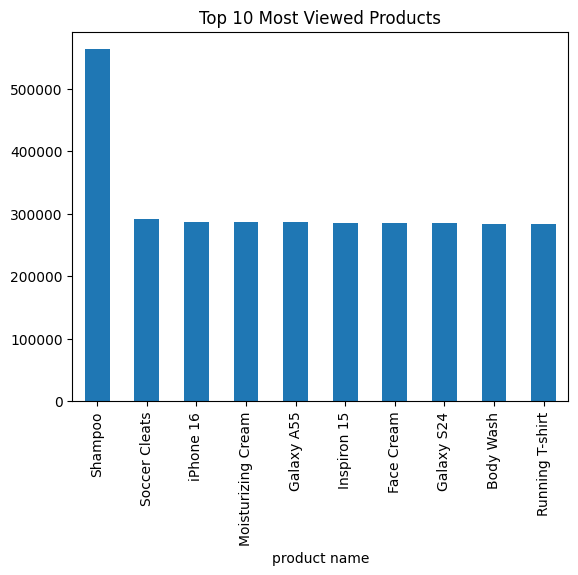

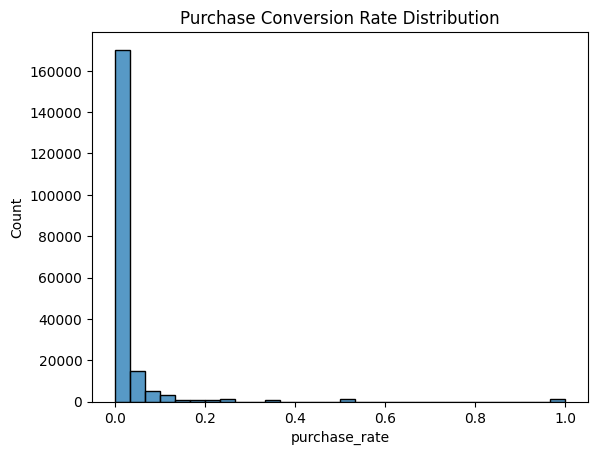

In [3]:

df = pd.read_csv("cleaned_ecommerce_data.csv")

# Top 10 most viewed products
top_products = df.groupby('product name')['views count'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title='Top 10 Most Viewed Products')
plt.show()

# Purchase conversion rate
df['purchase_rate'] = df['purchase count'] / df['views count']
sns.histplot(df['purchase_rate'], bins=30)
plt.title("Purchase Conversion Rate Distribution")
plt.show()


In [4]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
df = pd.read_csv("cleaned_ecommerce_data.csv")
label_enc = LabelEncoder()
df['category'] = label_enc.fit_transform(df['category'])
df['brand'] = label_enc.fit_transform(df['brand'])

df = df.groupby(['user id', 'product id'], as_index=False)['purchase count'].sum()

interaction_matrix = df.pivot(index='user id', columns='product id', values='purchase count').fillna(0)

sparse_matrix = csr_matrix(interaction_matrix.values)

np.savez("user_item_sparse.npz", 
         data=sparse_matrix.data, 
         indices=sparse_matrix.indices, 
         indptr=sparse_matrix.indptr, 
         shape=sparse_matrix.shape)

print("Sparse matrix saved successfully!")


Sparse matrix saved successfully!


In [5]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
import pickle
from implicit.als import AlternatingLeastSquares

df = pd.read_csv("cleaned_ecommerce_data.csv")
df['purchase count'] = df['purchase count'].fillna(0)

user_encoder = LabelEncoder()
product_encoder = LabelEncoder()
df['user_index'] = user_encoder.fit_transform(df['user id'])
df['product_index'] = product_encoder.fit_transform(df['product id'])

df = df.groupby(['user_index', 'product_index'], as_index=False)['purchase count'].sum()

interaction_matrix = csr_matrix((df['purchase count'], (df['user_index'], df['product_index'])))

np.savez("user_item_sparse.npz", 
         data=interaction_matrix.data, 
         indices=interaction_matrix.indices, 
         indptr=interaction_matrix.indptr, 
         shape=interaction_matrix.shape)

als = AlternatingLeastSquares(factors=50, regularization=0.1)
als.fit(interaction_matrix)

with open("als_model.pkl", "wb") as f:
    pickle.dump(als, f)

with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("product_encoder.pkl", "wb") as f:
    pickle.dump(product_encoder, f)

print("✅ ALS model, matrix, and encoders saved successfully!")


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

✅ ALS model, matrix, and encoders saved successfully!


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("cleaned_ecommerce_data.csv")

if 'review text' not in df.columns:
    raise ValueError("❌ 'review text' column not found in the dataset.")

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['review text'])

nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

with open("content_model.pkl", "wb") as f:
    pickle.dump({
        'model': nn_model,
        'tfidf': tfidf,
        'data': df 
    }, f)

print("✅ Content-Based Model Trained and Saved Successfully!")


✅ Content-Based Model Trained and Saved Successfully!


In [7]:
with open("content_model.pkl", "rb") as f:
    model_data = pickle.load(f)

nn_model = model_data['model']
tfidf = model_data['tfidf']
df = model_data['data']

index = 1  

tfidf_matrix = tfidf.transform(df['review text'])
distances, indices = nn_model.kneighbors(tfidf_matrix[index], n_neighbors=6)  # including self

print("🔁 Recommendations for item:", df.iloc[index]['review text'][:100])
for i in indices[0][1:]:  
    print(f"➡️ {df.iloc[i]['review text'][:100]}")

🔁 Recommendations for item: Not bad
➡️ Not bad
➡️ Bad
➡️ Not bad
➡️ Not bad
➡️ Bad


In [8]:
# SEARCH TOP 10 RECOMMENDED PRODUCTS NAME 

import pandas as pd
import numpy as np
import scipy.sparse as sp
import pickle

df = pd.read_csv("cleaned_ecommerce_data.csv")

with open("als_model.pkl", "rb") as f: als = pickle.load(f)
with open("user_encoder.pkl", "rb") as f: user_enc = pickle.load(f)
with open("product_encoder.pkl", "rb") as f: product_enc = pickle.load(f)

sparse_data = np.load("user_item_sparse.npz")
interaction_matrix = sp.csr_matrix((sparse_data['data'], sparse_data['indices'], sparse_data['indptr']),
                                   shape=sparse_data['shape'])

with open("content_model.pkl", "rb") as f:
    content_model_data = pickle.load(f)
nn_model = content_model_data['model']
tfidf = content_model_data['tfidf']
df_content = content_model_data['data']

product_id_to_name = dict(zip(df['product id'], df['product name']))

def get_top_popular_items(n=10):
    popular = df.groupby('product id')['purchase count'].sum().sort_values(ascending=False)
    top_items = popular.head(n).index.tolist()
    return [(pid, product_id_to_name.get(pid, "Unknown Product")) for pid in top_items]

def recommend(user_id, top_n=10):
    user_idx = user_id
    user_interactions = interaction_matrix[user_idx]
    recommended = als.recommend(user_idx, user_interactions, N=top_n * 2)

    recommendations = []
    for item in recommended:
        item_idx = int(item[0])
        if item_idx < len(df):
            product_id = df['product id'].iloc[item_idx]
            product_name = product_id_to_name.get(product_id, "Unknown Product")
            if (product_id, product_name) not in recommendations:
                recommendations.append((product_id, product_name))
        if len(recommendations) >= top_n:
            break
    
    if len(recommendations) < top_n:
        print("ALS returned fewer than 10 items. Filling with popular products.")
        popular_fallback = get_top_popular_items(top_n)
        for item in popular_fallback:
            if item not in recommendations:
                recommendations.append(item)
            if len(recommendations) >= top_n:
                break

    return recommendations


user_id = 10 
recommendations = recommend(user_id, top_n=10)

print("\nTop 10 Recommended Products:")
for idx, (pid, pname) in enumerate(recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Product Name: {pname}")


ALS returned fewer than 10 items. Filling with popular products.

Top 10 Recommended Products:
1. Product ID: P0004263 | Product Name: Hair Serum
2. Product ID: P0004499 | Product Name: Air Max
3. Product ID: P0004685 | Product Name: Galaxy S24
4. Product ID: P0004772 | Product Name: iPhone 14 Pro
5. Product ID: P0003802 | Product Name: iPhone 16
6. Product ID: P0004881 | Product Name: WH-1000XM5
7. Product ID: P0000974 | Product Name: Body Wash
8. Product ID: P0001542 | Product Name: Revolution 6
9. Product ID: P0000086 | Product Name: Beard Trimmer
10. Product ID: P0004351 | Product Name: Inspiron 15


In [9]:
# SEARCH THE PRODUCT DETAILS BASED ON USER ID 

df = pd.read_csv("cleaned_ecommerce_data.csv")

with open("als_model.pkl", "rb") as f:
    als = pickle.load(f)
    
with open("user_encoder.pkl", "rb") as f:
    user_enc = pickle.load(f)
with open("product_encoder.pkl", "rb") as f:
    product_enc = pickle.load(f)

sparse_data = np.load("user_item_sparse.npz")
interaction_matrix = sp.csr_matrix((sparse_data['data'], sparse_data['indices'], sparse_data['indptr']),
                                   shape=sparse_data['shape'])

with open("content_model.pkl", "rb") as f:
    content_model_data = pickle.load(f)
nn_model = content_model_data['model']
tfidf = content_model_data['tfidf']
df_content = content_model_data['data']

product_id_to_name = dict(zip(df['product id'], df['product name']))
index_to_product_id = dict(enumerate(df['product id']))

def recommend(user_id, top_n=5):
    user_idx = user_id
    user_interactions = interaction_matrix[user_idx]
    recommended = als.recommend(user_idx, user_interactions, N=top_n)
    recommendations = []
    for row in recommended:
        item_idx = int(row[1])  # First element is item index
        product_id = df['product id'].iloc[item_idx]
        product_name = product_id_to_name.get(product_id, "Unknown Product")
        recommendations.append((product_id, product_name))
    
    return recommendations

user_id = 0 
recommendations = recommend(user_id)

for pid, pname in recommendations:
    print(f"🛒 Product ID: {pid} | Product Name: {pname}")

🛒 Product ID: P0003766 | Product Name: Beard Trimmer
🛒 Product ID: P0004499 | Product Name: Air Max


In [10]:
# SEARCH THE PRODUCTS BASED ON PRODUCTS NAME 
import pandas as pd

df = pd.read_csv("cleaned_ecommerce_data.csv")

def search_products_by_name(search_query):
    search_query = search_query.lower()
    matches = df[df['product name'].str.lower().str.contains(search_query, na=False)]
    return matches[['product id', 'product name', 'brand','price', 'rating']]


In [11]:
# Example usage:
search_term = "phone"  
results = search_products_by_name(search_term)

print(results)

       product id   product name  brand    price  rating
8        P0003300      iPhone 16  Apple  7639.80       3
22       P0003286      iPhone 16  Apple  2235.54       5
38       P0000709      iPhone 15  Apple  9889.90       3
52       P0002523      iPhone 16  Apple  6833.45       1
53       P0003119  iPhone 14 Pro  Apple  4070.39       5
...           ...            ...    ...      ...     ...
199959   P0004975      iPhone 15  Apple  7295.28       5
199964   P0002316      iPhone 15  Apple  5412.44       4
199970   P0001437      iPhone 15  Apple  5420.78       2
199995   P0003781  iPhone 14 Pro  Apple  1267.85       2
199999   P0001960  iPhone 14 Pro  Apple  8115.74       1

[16752 rows x 5 columns]


In [12]:
print(df.columns.tolist())


['user id', 'product id', 'category', 'brand', 'price', 'views count', 'cart addition', 'purchase count', 'rating', 'review text', 'review sentiment', 'session id', 'timestamp', 'device type', 'referral source', 'order id', 'payment method', 'discount used', 'return status', 'search query', 'click-through rate', 'stock status', 'popularity score', 'delivery time estimate', 'product name']


In [13]:
df = pd.read_csv("cleaned_ecommerce_data.csv")

df.columns = df.columns.str.strip() 
print("📋 Available Columns:", df.columns.tolist())


📋 Available Columns: ['user id', 'product id', 'category', 'brand', 'price', 'views count', 'cart addition', 'purchase count', 'rating', 'review text', 'review sentiment', 'session id', 'timestamp', 'device type', 'referral source', 'order id', 'payment method', 'discount used', 'return status', 'search query', 'click-through rate', 'stock status', 'popularity score', 'delivery time estimate', 'product name']


In [14]:
# Get all unique User IDs
user_ids = df['user id'].dropna().unique()

print("✅ Available User IDs in the dataset:\n")
for uid in user_ids:
    print("🆔", uid)

✅ Available User IDs in the dataset:

🆔 U0017918
🆔 U0002824
🆔 U0000662
🆔 U0013875
🆔 U0010805
🆔 U0004888
🆔 U0003703
🆔 U0006636
🆔 U0010074
🆔 U0003657
🆔 U0005245
🆔 U0005477
🆔 U0018625
🆔 U0006851
🆔 U0005895
🆔 U0019913
🆔 U0019927
🆔 U0019674
🆔 U0003253
🆔 U0018932
🆔 U0019534
🆔 U0017787
🆔 U0000843
🆔 U0007985
🆔 U0004751
🆔 U0017238
🆔 U0015908
🆔 U0011742
🆔 U0011423
🆔 U0010218
🆔 U0008470
🆔 U0005396
🆔 U0004435
🆔 U0003187
🆔 U0011017
🆔 U0006821
🆔 U0014816
🆔 U0014535
🆔 U0018868
🆔 U0017657
🆔 U0016925
🆔 U0017952
🆔 U0017779
🆔 U0010622
🆔 U0019609
🆔 U0002484
🆔 U0007870
🆔 U0010650
🆔 U0010954
🆔 U0006341
🆔 U0019651
🆔 U0000909
🆔 U0006654
🆔 U0019816
🆔 U0006926
🆔 U0000387
🆔 U0018770
🆔 U0015877
🆔 U0006896
🆔 U0015230
🆔 U0003529
🆔 U0007995
🆔 U0014474
🆔 U0005790
🆔 U0002272
🆔 U0016737
🆔 U0001244
🆔 U0000197
🆔 U0007175
🆔 U0019731
🆔 U0008561
🆔 U0016488
🆔 U0008736
🆔 U0003777
🆔 U0007998
🆔 U0018570
🆔 U0012478
🆔 U0012135
🆔 U0013600
🆔 U0015183
🆔 U0001802
🆔 U0001137
🆔 U0013323
🆔 U0007841
🆔 U0010837
🆔 U0001430
🆔 U0001700
🆔 U00

In [15]:
# Search for products containing a term (e.g., "phone")
search_term = "phone"
matching_products = df[df['product name'].str.contains(search_term, case=False, na=False)]

unique_products = matching_products.drop_duplicates(subset=['product name', 'brand'])

print(f"Available products for search: '{search_term}'\n")
print(unique_products[['product name', 'brand', 'category', 'price']])


Available products for search: 'phone'

     product name  brand     category    price
8       iPhone 16  Apple  Smartphones  7639.80
38      iPhone 15  Apple  Smartphones  9889.90
53  iPhone 14 Pro  Apple  Smartphones  4070.39


In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("cleaned_ecommerce_data.csv")
df.columns = df.columns.str.strip()   

user_id = input("Enter User ID: ").strip()
product_name = input("Enter Product Name: ").strip().lower()
n_recommendations = int(input("Enter number of recommendations: "))

df['product name_lower'] = df['product name'].str.lower()

product_row = df[df['product name_lower'] == product_name]

if product_row.empty:
    partial_matches = df[df['product name_lower'].str.contains(product_name, na=False)]
    
    if partial_matches.empty:
        print(f"❌ No product found containing '{product_name}' in its name.")
    else:
        product_row = partial_matches.iloc[[0]]   
        matched_name = product_row['product name'].values[0]
        print(f"🔍 Using closest match: '{matched_name}'")

if not product_row.empty:
    category = product_row['category'].values[0]

    category_df = df[df['category'] == category]
    category_products = category_df['product name'].dropna().unique()

    if len(category_products) <= 1:
        print(f"⚠️ Not enough products in category '{category}' to make recommendations.")
    else:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(category_products)

        try:
            original_product_names = [p.lower() for p in category_products]
            match_name = product_row['product name'].values[0].lower()
            index = original_product_names.index(match_name)

            similarity_scores = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()

            similar_indices = similarity_scores.argsort()[::-1]
            similar_indices = [i for i in similar_indices if i != index]

            top_n = min(n_recommendations, len(similar_indices))
            recommended_products = category_products[similar_indices[:top_n]]

            print(f"\nUser ID: {user_id}")
            print(f"Recommendations for '{match_name}' (Category: {category}):\n")
            for prod in recommended_products:
                print("➡️", prod)

            if top_n < n_recommendations:
                print(f"\nℹ️ Only {top_n} similar products found in the same category.")

        except ValueError:
            print(f"❌ Product '{match_name}' not found in TF-IDF list.")


Enter User ID:  U0008199
Enter Product Name:  tv
Enter number of recommendations:  5


🔍 Using closest match: 'Bravia TV'

User ID: U0008199
Recommendations for 'bravia tv' (Category: Electronics):

➡️ PlayStation 5
➡️ Alienware m15
➡️ Inspiron 15
➡️ Envy x360
➡️ Pavilion 15


In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("cleaned_ecommerce_data.csv")
df.columns = df.columns.str.strip().str.lower()   

all_product_names = df['product name'].dropna().unique()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_product_names)

def get_recommendations(user_id, n_recommendations=5):
    user_history = df[df['user id'] == user_id]
    interacted_products = user_history['product name'].dropna().unique()

    if len(interacted_products) == 0:
        print(f"❌ No product interaction found for User ID '{user_id}'.")
        return

    categories = df[df['product name'].isin(interacted_products)]['category'].dropna().unique()
    
    relevant_products = df[df['category'].isin(categories)]['product name'].dropna().unique()

    tfidf_subset = vectorizer.transform(relevant_products)

    scores = []
    for prod in interacted_products:
        try:
            idx = list(all_product_names).index(prod)
            sim = cosine_similarity(tfidf_matrix[idx], tfidf_subset).flatten()
            scores.append(sim)
        except ValueError:
            continue

    if not scores:
        print(f"❌ Could not compute recommendations for any product in user's history.")
        return

    avg_score = sum(scores) / len(scores)
    
    recommendations = []
    for i in avg_score.argsort()[::-1]:
        candidate = relevant_products[i]
        if candidate not in interacted_products and candidate not in recommendations:
            recommendations.append(candidate)
        if len(recommendations) >= n_recommendations:
            break

    print(f"\nUser ID: {user_id}")
    print(f"Personalized Recommendations based on your history:\n")
    for prod in recommendations:
        print("➡️", prod)

    if len(recommendations) < n_recommendations:
        print(f"\nℹ️ Only {len(recommendations)} suitable recommendations found.")

while True:
    user_input = input("\nEnter User ID (or type 'exit' to quit): ").strip()
    if user_input.lower() == 'exit':
        print("👋 Exiting recommendation system.")
        break
    try:
        n_recs = int(input("Enter number of recommendations: ").strip())
    except ValueError:
        print("❌ Invalid number. Please enter an integer.")
        continue

    get_recommendations(user_input, n_recs)



Enter User ID (or type 'exit' to quit):  U0008189
Enter number of recommendations:  5



User ID: U0008189
Personalized Recommendations based on your history:

➡️ Spectre x360
➡️ Galaxy A55
➡️ Galaxy S24
➡️ iPhone 15
➡️ iPhone 16



Enter User ID (or type 'exit' to quit):  U0001212
Enter number of recommendations:  5



User ID: U0001212
Personalized Recommendations based on your history:

➡️ Inspiron 15
➡️ iPhone 14 Pro
➡️ Spectre x360
➡️ Running T-shirt
➡️ Galaxy S24



Enter User ID (or type 'exit' to quit):  exit


👋 Exiting recommendation system.


In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("cleaned_ecommerce_data.csv")
df.columns = df.columns.str.strip().str.lower()  
df['product name'] = df['product name'].str.strip().str.lower()   
df['brand'] = df['brand'].str.strip().str.lower()                 
df['category'] = df['category'].str.strip().str.lower()          

def recommend_similar_products(user_id, product_name, n_recommendations):
    product_name = product_name.strip().lower()   
    df_user = df[df['user id'] == (user_id)]
    if df_user.empty:
        print(f"❌ User ID '{user_id}' not found.")
        return

    if product_name not in df['product name'].values:
        print(f"❌ Product '{product_name}' not found in the dataset.")
        return

    target_row = df[df['product name'] == product_name].iloc[0]
    target_category = target_row['category']
    target_brand = target_row['brand']

    same_category_products = df[df['category'] == target_category]['product name'].dropna().unique()

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(same_category_products)

    try:
        idx = list(same_category_products).index(product_name)
    except ValueError:
        print("❌ Target product not found in the category.")
        return

    similarity_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    interacted_products = df_user['product name'].dropna().unique()
    similar_products = [same_category_products[i] for i in similarity_scores.argsort()[::-1] 
                        if same_category_products[i] != product_name and same_category_products[i] not in interacted_products]

    user_brands = df_user['brand'].dropna().unique()
    user_categories = df_user['category'].dropna().unique()
    product_info = df[['product name', 'brand', 'category']].drop_duplicates()

    personalized_scores = []
    for prod in similar_products:
        row = product_info[product_info['product name'] == prod]
        if row.empty:
            continue
        brand = row['brand'].values[0]
        category = row['category'].values[0]
        score = similarity_scores[list(same_category_products).index(prod)]

        if category in user_categories:
            score += 0.15
        if brand in user_brands:
            score += 0.10

        personalized_scores.append((prod, score))

    personalized_scores.sort(key=lambda x: x[1], reverse=True)
    final_recommendations = [prod for prod, _ in personalized_scores[:n_recommendations]]

    print(f"\nUser ID: {user_id}")
    print(f" Recommendations for '{product_name.title()}' (Category: {target_category.title()}):\n")
    for prod in final_recommendations:
        print("➡️", prod.title())

    if len(final_recommendations) < n_recommendations:
        print(f"\nℹ️ Only {len(final_recommendations)} suitable recommendations found.")

while True:
    user_id = input("\nEnter User ID (or type 'exit' to quit): ").strip()
    if user_id.lower() == 'exit':
        break

    product_name = input("Enter Product Name: ").strip()
    try:
        n = int(input("Enter number of recommendations: "))
    except ValueError:
        print("❌ Please enter a valid number.")
        continue

    recommend_similar_products(user_id, product_name, n)



Enter User ID (or type 'exit' to quit):  U0008200
Enter Product Name:  shampoo
Enter number of recommendations:  5



User ID: U0008200
 Recommendations for 'Shampoo' (Category: Beauty & Personal Care):

➡️ Body Wash
➡️ Moisturizing Cream
➡️ Face Cream
➡️ Hair Serum

ℹ️ Only 4 suitable recommendations found.



Enter User ID (or type 'exit' to quit):  U0007845
Enter Product Name:  blazer
Enter number of recommendations:  5



User ID: U0007845
 Recommendations for 'Blazer' (Category: Fashion):

➡️ Suit
➡️ Running T-Shirt
➡️ Soccer Cleats
➡️ Jordan 1
➡️ Air Max



Enter User ID (or type 'exit' to quit):  exit


In [19]:
# NEW

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pickle

df = pd.read_csv("cleaned_ecommerce_data.csv")
df['review text'] = df['review text'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['review text'])

nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

with open("content_model.pkl", "wb") as f:
    pickle.dump({'model': nn_model, 'tfidf': tfidf, 'data': df}, f)


In [21]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare embeddings for review texts
df = pd.read_csv("cleaned_ecommerce_data.csv")
df['review text'] = df['review text'].fillna('')
product_texts = df['review text'].tolist()
embeddings = model.encode(product_texts, convert_to_tensor=True)

In [22]:
np.save("bert_embeddings.npy", embeddings.cpu().numpy())


In [23]:
df['product name'].dropna().unique()[:20]


array(['Washing Machine', 'Shampoo', 'Ultraboost Shoes', 'Hair Dryer',
       'Refrigerator', 'Revolution 6', 'WH-1000XM5', 'iPhone 16',
       'Hair Serum', 'Galaxy A55', 'Blazer', 'Electric Toothbrush',
       'Galaxy Z Fold5', 'Formal Shirt', 'Suit', 'Moisturizing Cream',
       'Jordan 1', 'XPS 13', 'Spectre x360', 'Pavilion 15'], dtype=object)

In [24]:
def recommend_similar_bert(index, top_n=5):
    query_embedding = embeddings[index]
    cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_n * 5)  # fetch more in case of duplicates

    seen = set()
    results = []

    for score, idx in zip(top_results[0], top_results[1]):
        idx = int(idx)
        name = df.iloc[idx]['product name']
        pid = df.iloc[idx]['product id']
        if (name, pid) not in seen:
            seen.add((name, pid))
            results.append((name, pid, float(score)))
        if len(results) >= top_n:
            break

    print(f"Input Review: {df.iloc[index]['review text'][:100]}")
    print("\nTop Recommendations:\n")
    for name, pid, score in results:
        print(f"{name} | Product ID: {pid} | Score: {score:.4f}")


In [25]:
def get_index_by_product_name(name):
    match = df[df['product name'].str.lower().str.contains(name.lower(), na=False)]
    if not match.empty:
        print("🔍 Matched Product(s):")
        print(match[['product name', 'product id']].drop_duplicates().head())
        return match.index[0]
    else:
        print("❌ Product not found.")
        return None


In [26]:
product_name = "iphone"
index = get_index_by_product_name(product_name)
if index is not None:
    recommend_similar_bert(index, top_n=5)


🔍 Matched Product(s):
     product name product id
8       iPhone 16   P0003300
22      iPhone 16   P0003286
38      iPhone 15   P0000709
52      iPhone 16   P0002523
53  iPhone 14 Pro   P0003119
Input Review: Average

Top Recommendations:

iPhone 15 | Product ID: P0002787 | Score: 1.0000
Moisturizing Cream | Product ID: P0000180 | Score: 1.0000
OLED TV | Product ID: P0004601 | Score: 1.0000
Shampoo | Product ID: P0000858 | Score: 1.0000
Suit | Product ID: P0001878 | Score: 1.0000


In [27]:
def evaluate_model(model, sparse_matrix):
    coo = sparse_matrix.tocoo()
    
    predictions = np.array([
        np.dot(model.user_factors[u], model.item_factors[i])
        for u, i in zip(coo.row, coo.col)
    ])
    
    actual_ratings = coo.data   
    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    print(f"✅ RMSE (Root Mean Squared Error): {rmse:.4f}")


In [28]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer, util

with open("user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("product_encoder.pkl", "rb") as f:
    product_encoder = pickle.load(f)
with open("als_model.pkl", "rb") as f:
    als_model = pickle.load(f)

sparse_data = np.load("user_item_sparse.npz")
interaction_matrix = csr_matrix((sparse_data['data'], sparse_data['indices'], sparse_data['indptr']),
                                shape=sparse_data['shape'])

df = pd.read_csv("cleaned_ecommerce_data.csv")
df['user_index'] = user_encoder.transform(df['user id'])
df['product_index'] = product_encoder.transform(df['product id'])

model = SentenceTransformer("all-MiniLM-L6-v2",local_files_only=True)
embeddings = model.encode(df['review text'].fillna(''), convert_to_tensor=True)

def precision_at_k(actual, predicted, k):
    predicted = predicted[:k]
    return len(set(actual) & set(predicted)) / k if k > 0 else 0

def recall_at_k(actual, predicted, k):
    predicted = predicted[:k]
    return len(set(actual) & set(predicted)) / len(set(actual)) if len(actual) > 0 else 0

def recommend_similar_bert(index, top_n=5):
    query_embedding = embeddings[index]
    cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
    top_results = np.argpartition(-cos_scores, top_n + 1)[:top_n + 1]
    top_results = [i for i in top_results if i != index][:top_n]
    return df.iloc[top_results]['product id'].values

precision_list = []
recall_list = []
fallbacks_used = 0

for user_id in df['user id'].unique()[:200]:
    if user_id in user_encoder.classes_:
        try:
            user_idx = user_encoder.transform([user_id])[0]
            recommended_items = als_model.recommend(user_idx, interaction_matrix[user_idx], N=10)[0]
            recommended_ids = product_encoder.inverse_transform(recommended_items)

            actual_product_ids = df[df['user_index'] == user_idx]['product id'].unique()

            p = precision_at_k(actual_product_ids, recommended_ids, 5)
            r = recall_at_k(actual_product_ids, recommended_ids, 5)

            if r == 0:
                fallback_index = df[df['user_index'] == user_idx].index[0]  
                recommended_ids = recommend_similar_bert(fallback_index, top_n=5)
                p = precision_at_k(actual_product_ids, recommended_ids, 5)
                r = recall_at_k(actual_product_ids, recommended_ids, 5)
                fallbacks_used += 1

            precision_list.append(p)
            recall_list.append(r)
        except Exception as e:
            pass   

def evaluate_rmse(model, matrix):
    coo = matrix.tocoo()
    predictions = np.array([
        np.dot(model.user_factors[u], model.item_factors[i])
        for u, i in zip(coo.row, coo.col)
    ])
    return np.sqrt(mean_squared_error(coo.data, predictions))

rmse = evaluate_rmse(als_model, interaction_matrix)

print("\n✅ Final Evaluation Metrics")
print("---------------------------")
print(f"RMSE (ALS Only)     : {rmse:.4f}")
print(f"Avg Precision@5     : {np.mean(precision_list):.4f}")
print(f"Avg Recall@5        : {np.mean(recall_list):.4f}")
print(f"Fallbacks to BERT   : {fallbacks_used} out of {len(precision_list)} users")



✅ Final Evaluation Metrics
---------------------------
RMSE (ALS Only)     : 0.6899
Avg Precision@5     : 0.0040
Avg Recall@5        : 0.0017
Fallbacks to BERT   : 200 out of 200 users


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error

df = pd.read_csv("cleaned_ecommerce_data.csv")

user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df['user_index'] = user_encoder.fit_transform(df['user id'])
df['product_index'] = product_encoder.fit_transform(df['product id'])

df_grouped = df.groupby(['user_index', 'product_index'], as_index=False)['purchase count'].sum()

interaction_matrix = csr_matrix((df_grouped['purchase count'],
                                (df_grouped['user_index'], df_grouped['product_index'])))

def evaluate_rmse(model, matrix):
    coo = matrix.tocoo()
    predictions = np.array([
        np.dot(model.user_factors[u], model.item_factors[i])
        for u, i in zip(coo.row, coo.col)
    ])
    return np.sqrt(mean_squared_error(coo.data, predictions))

factors_list = [20, 50, 100]
regularization_list = [0.01, 0.1, 1]
iterations_list = [10, 20]

best_rmse = float('inf')
best_params = {}

print("🔍 Starting ALS Hyperparameter Tuning...")

for factors in factors_list:
    for reg in regularization_list:
        for iterations in iterations_list:
            model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iterations)
            model.fit(interaction_matrix)
            rmse = evaluate_rmse(model, interaction_matrix)
            print(f"factors={factors}, reg={reg}, iterations={iterations} --> RMSE={rmse:.4f}")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'factors': factors, 'regularization': reg, 'iterations': iterations}

print("\n✅ Best ALS Parameters:", best_params)
print("✅ Best RMSE:", best_rmse)


🔍 Starting ALS Hyperparameter Tuning...


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.01, iterations=10 --> RMSE=0.6995


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.01, iterations=20 --> RMSE=0.6993


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=0.1, iterations=10 --> RMSE=0.6995


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=0.1, iterations=20 --> RMSE=0.6993


  0%|          | 0/10 [00:00<?, ?it/s]

factors=20, reg=1, iterations=10 --> RMSE=0.7004


  0%|          | 0/20 [00:00<?, ?it/s]

factors=20, reg=1, iterations=20 --> RMSE=0.7003


  0%|          | 0/10 [00:00<?, ?it/s]

factors=50, reg=0.01, iterations=10 --> RMSE=0.6901


  0%|          | 0/20 [00:00<?, ?it/s]

factors=50, reg=0.01, iterations=20 --> RMSE=0.6897


  0%|          | 0/10 [00:00<?, ?it/s]

factors=50, reg=0.1, iterations=10 --> RMSE=0.6902


  0%|          | 0/20 [00:00<?, ?it/s]

factors=50, reg=0.1, iterations=20 --> RMSE=0.6898


  0%|          | 0/10 [00:00<?, ?it/s]

factors=50, reg=1, iterations=10 --> RMSE=0.6924


  0%|          | 0/20 [00:00<?, ?it/s]

factors=50, reg=1, iterations=20 --> RMSE=0.6920


  0%|          | 0/10 [00:00<?, ?it/s]

factors=100, reg=0.01, iterations=10 --> RMSE=0.6749


  0%|          | 0/20 [00:00<?, ?it/s]

factors=100, reg=0.01, iterations=20 --> RMSE=0.6743


  0%|          | 0/10 [00:00<?, ?it/s]

factors=100, reg=0.1, iterations=10 --> RMSE=0.6751


  0%|          | 0/20 [00:00<?, ?it/s]

factors=100, reg=0.1, iterations=20 --> RMSE=0.6746


  0%|          | 0/10 [00:00<?, ?it/s]

factors=100, reg=1, iterations=10 --> RMSE=0.6795


  0%|          | 0/20 [00:00<?, ?it/s]

factors=100, reg=1, iterations=20 --> RMSE=0.6788

✅ Best ALS Parameters: {'factors': 100, 'regularization': 0.01, 'iterations': 20}
✅ Best RMSE: 0.6743112573558288
